In [5]:
import numpy as np

from ClassifierMetric.utils.plots import plot_class_score
from ClassifierMetric.datamodules.jetnet.datasets import JetNetDataset
from ClassifierMetric.datamodules.jetnet.dataloaders import JetNetDataLoader
from ClassifierMetric.train.trainer import ModelClassifierTest

In [12]:
def evaluate_models(dir, Model, Config, device='cuda:1', tag=None):
    model_dir='/home/df630/ClassifierMetric/results/{}'.format(dir)
    config = Config.load(path=model_dir + "/config.json")
    config.workdir = model_dir
    config.device = device
    config.tag = tag
    classifier = Model(model_config=config)
    datasets = JetNetDataset(dir_path = '/home/df630/ClassifierMetric/data/', 
                            datasets = config.datasets,
                            class_labels = config.labels,
                            max_num_jets = config.max_num_jets,
                            max_num_constituents = config.max_num_constituents,
                            preprocess = config.preprocess,
                            particle_features = config.features,
                            remove_negative_pt = True
                            ) 
    dataloader = JetNetDataLoader(datasets=datasets, data_split_fracs=config.data_split_fracs, batch_size=config.batch_size)
    classifier = ModelClassifierTest(classifier = classifier, 
                                    dataloader = dataloader,
                                    epochs = config.epochs, 
                                    lr = config.lr, 
                                    early_stopping = config.early_stopping,
                                    warmup_epochs = config.warmup_epochs,
                                    workdir = config.workdir,
                                    seed = config.seed)
    classifier.load_model(path=config.workdir + '/best_model.pth')
    classifier.test(class_labels=config.labels)
    return classifier, config


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_score(predictions: dict=None,
                     class_labels: dict=None,
                     title: str=None,
                     workdir: str=None, 
                     reference: str=None,
                     figsize=(4,4), 
                     bins=np.arange(-0.03, 1.03, 0.01), 
                     lw=0.75,
                     color=None,
                     alpha=0.2,
                     xlog=False, 
                     ylog=True,
                     density=False, 
                     xlim=(0,1),
                    legend_loc='upper left',
                    legend_fontsize=10,
                    legend=None):

    ref_label = class_labels[reference]
    get_name = {v: k for k, v in class_labels.items()}
    fig, ax = plt.subplots(1, figsize=figsize)    
    N = int(1e10) if density else predictions[-1].shape[0]
    for label, score in predictions.items():
        if label == 'datasets': continue
        test = True if label == -1 else False
        sns.histplot(x=score[:N, ref_label], 
                     bins=bins, 
                     element="step", 
                     log_scale=(xlog, ylog), 
                     lw = 0 if test else lw, 
                     ls = '--' if '(uncond)' in legend[label] else '-',
                     fill=test, 
                     color = color[label],
                     alpha=alpha if test else 1, 
                     ax=ax, 
                     stat='density' if density else 'count',
                     label=get_name[label] if legend is None else legend[label]) 
    plt.xlabel(r'multi-classifier score')
    plt.ylabel(r'Normalised Entries')
    plt.xlim(xlim)
    if title is not None:
        plt.title('{}'.format(title), fontsize=12)
    plt.legend(loc=legend_loc, fontsize=legend_fontsize, frameon=False)
    plt.savefig(workdir+'/classifier_score.png')

# ParticleNet classifier: JetNet150

In [3]:
from ClassifierMetric.models.particlenet import ParticleNet 
from ClassifierMetric.configs.particlenet_config import ParticleNetConfig

classifier_150, config_150 = evaluate_models(dir="ParticleNet.tops.150_2023.08.16_02h28__1", 
                                            Model=ParticleNet,
                                            Config=ParticleNetConfig,
                                            device='cuda:0')

+----------------------+------------------------------------------------------------------------+
| Key                  | Value                                                                  |
+----------------------+------------------------------------------------------------------------+
| data_name            | tops                                                                   |
| features             | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                         |
| preprocess           | ['standardize']                                                        |
| datasets             | flow_cond: ['fm_tops150_cond_mp200nfe.h5', 'etaphipt']                 |
|                      | diff_cond: ['diff_tops150_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                      | flow_uncond: ['fm_tops150_mp200nfe.h5', 'etaphipt']                    |
|                      | diff_uncond: ['diff_tops150_midpoint_100_csts.h5', 'etaphipt_frac']    |
|                   

2023-08-22 06:20:51.446509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 06:20:51.885990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


testing:   0%|          | 0/222 [00:00<?, ?it/s]

### Classifier score plot

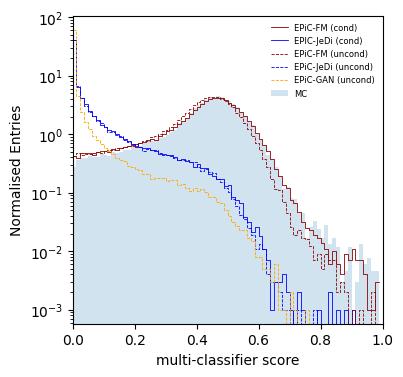

In [17]:
legend_150 = {0 : 'EPiC-FM (cond)', 
              1 : 'EPIC-JeDi (cond)', 
              2 : 'EPiC-FM (uncond)',
              3 : 'EPiC-JeDi (uncond)', 
              4 : 'EPiC-GAN (uncond)', 
             -1 : 'MC'} # test data

color_150 = {0 : 'darkred', 
              1 : 'blue', 
              2 : 'darkred', 
              3 : 'blue', 
              4 : 'orange',
              -1 : None} # test data


plot_class_score(predictions=classifier_150.predictions,
                class_labels=config_150.labels,
                reference='flow_cond',
                figsize=(4,4), 
                xlim=(0.0,1),
                ylog=True,
                bins=np.arange(0.0, 1, 0.0125),
                workdir=config_150.workdir,
                density=True,
                color=color_150,
                lw=0.6,
                legend=legend_150,
                legend_fontsize=6,
                legend_loc='upper right')

### Log posteriors

In [7]:

classifier_150.log_posterior

{0: tensor(-3.6192),
 1: tensor(-6.0636),
 2: tensor(-3.6579),
 3: tensor(-6.0862),
 4: tensor(-6.6726),
 -1: tensor(-3.7070)}

# ParticleNet classifier: JetNet30

In [21]:
from ClassifierMetric.models.particlenet import ParticleNet 
from ClassifierMetric.configs.particlenet_config import ParticleNetConfig

classifier_30, config_30 = evaluate_models(dir="ParticleNet.tops.30_2023.08.21_19h13__1", 
                                            Model=ParticleNet,
                                            Config=ParticleNetConfig,
                                            device='cuda:0')

+----------------------+-----------------------------------------------------------------------+
| Key                  | Value                                                                 |
+----------------------+-----------------------------------------------------------------------+
| data_name            | tops                                                                  |
| features             | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                        |
| preprocess           | ['standardize']                                                       |
| datasets             | flow_cond: ['fm_tops30_cond_mp200nfe.h5', 'etaphipt']                 |
|                      | diff_cond: ['diff_tops30_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                      | pc_diff_cond: ['pc_tops30_em_200_csts.h5', 'etaphipt_frac']           |
|                      | flow_uncond: ['fm_tops30_mp200nfe.h5', 'etaphipt']                    |
|                      | diff_

testing:   0%|          | 0/261 [00:00<?, ?it/s]

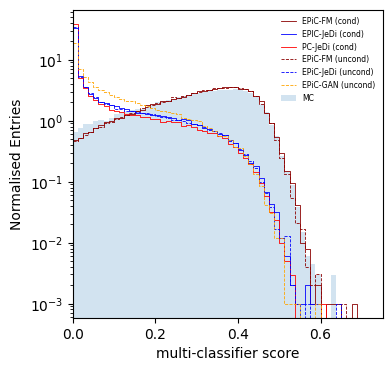

In [24]:
legend_30 = {0 : 'EPiC-FM (cond)', 
              1 : 'EPIC-JeDi (cond)', 
              2 : 'PC-JeDi (cond)',
              3 : 'EPiC-FM (uncond)',
              4 : 'EPiC-JeDi (uncond)', 
              5 : 'EPiC-GAN (uncond)', 
             -1 : 'MC'} # test data

color_30 = {0 : 'darkred', 
              1 : 'blue', 
              2 : 'red', 
              3 : 'darkred', 
              4 : 'blue' ,
              5: 'orange',
              -1 : None} # test data


plot_class_score(predictions=classifier_30.predictions,
                class_labels=config_30.labels,
                reference='flow_cond',
                figsize=(4,4), 
                xlim=(0.0, 0.75),
                ylog=True,
                bins=np.arange(0.0, 0.75, 0.0125),
                workdir=config_30.workdir,
                density=True,
                color=color_30,
                lw=0.6,
                legend=legend_30,
                legend_fontsize=5.5,
                legend_loc='upper right')

In [5]:
classifier_30.log_posterior

{0: tensor(-2.4917),
 1: tensor(-3.6780),
 2: tensor(-4.0048),
 3: tensor(-2.4928),
 4: tensor(-3.7579),
 5: tensor(-3.4482),
 -1: tensor(-2.5281)}